In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import psycopg2
from postgis.psycopg import register
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from shapely.geometry import box
import project_path
from db_importer.settings import *
import scipy.stats
from scipy.stats import ks_2samp
from statsmodels.distributions.empirical_distribution import ECDF

class DatabaseConnection(object):
    def __enter__(self):
        self.conn = psycopg2.connect(f"dbname='{DB_NAME}' user='{DB_USER}' password='{DB_PASSWORD}' host='{DB_HOST}' port='{DB_PORT}'")
        self.conn.autocommit = True

        register(self.conn)
        self.cur = self.conn.cursor()

        return self.cur

    def __exit__(self, exc_type, exc_val, exc_tb):
        if exc_tb is None:
            self.conn.commit()
            self.cur.close()
            self.conn.close()
        else:
            self.conn.rollback()
            self.cur.close()
            self.conn.close()

In [2]:
# plotting config
columnwidth = 3.5
textwidth = 3.5 * 2 + 0.25
figsize = (columnwidth * 0.97, 2.25)
params = {
     "pdf.fonttype": 42,
     "font.family": "serif",
     "font.serif": "Linux Libertine",
     # "font.sans-serif": [],
     "font.monospace": [],
     # Make the legend/label fonts a little smaller
     "font.size": 8,
     "axes.labelsize": 8,
     "axes.titlesize": 8,
     "legend.fontsize": 6,
     "legend.title_fontsize": 8,
     "xtick.labelsize": 7,
     "ytick.labelsize": 7,
     "figure.figsize": figsize,
     "figure.autolayout": True,
     # save some space around figures when saving
     "savefig.bbox": "tight",
     "savefig.pad_inches": 0.025,
}
pdf_params = {
     "text.usetex": True,
     "pgf.texsystem": "pdflatex",
     "pgf.rcfonts": False,
     "pgf.preamble": "\n".join(
         [
             # put LaTeX preamble declarations here
             r"\usepackage[utf8x]{inputenc}",
             r"\usepackage[T1]{fontenc}",
         ]
     ),
}

In [3]:
start_rect = box(13.4155, 52.5213, 13.4167, 52.5219)
end_rect = box(13.4149, 52.5223, 13.4159, 52.5229)

def get_SUMO_durations(x):
    
    mask_first = x.apply(lambda coord: start_rect.contains(Point(coord['vehicle_x'], coord['vehicle_y'])), axis=1)
    mask_end = x.apply(lambda coord: end_rect.contains(Point(coord['vehicle_x'], coord['vehicle_y'])), axis=1)
    vehicle_id = x.iloc[0].vehicle_id
    try:
        start = x[mask_first==True].iloc[0].timestep_time
        end = x[mask_end==True].iloc[0].timestep_time
        return (vehicle_id, end - start)
    except: 
        return None, None
    

In [4]:
files= ['../sim_data/alex_default.csv', '../sim_data/alex_new_params_all_new.csv', '../sim_data/alex_new_params_slow_new.csv', '../sim_data/alex_new_params_medium_new.csv', '../sim_data/alex_new_params_fast_new.csv']

durations_arr = []

for file in files:
    df = pd.read_csv(file, delimiter=';')
    print(len(df))
    print(file)
    df = df[df.vehicle_id.str.startswith('flow_2', na=False)]
    
    grouped = df.groupby('vehicle_id')
    durations = grouped.apply(lambda x: get_SUMO_durations(x)[1]).dropna()
    durations = durations[(durations < 150)]
    durations_arr.append(durations.values)

    


23004
../sim_data/alex_default.csv
23923
../sim_data/alex_new_params_all_new.csv
27110
../sim_data/alex_new_params_slow_new.csv
25887
../sim_data/alex_new_params_medium_new.csv
90202
../sim_data/alex_new_params_fast_new.csv


In [5]:
from statsmodels.distributions.empirical_distribution import ECDF
from adsp.db_utils import build_and_execute_query

with DatabaseConnection() as cur:
    velo_filter = lambda name: f"{name} > 0.2 AND {name} != 'NaN' AND {name} < 15"
    group_q = lambda perc: f"""SELECT percentile_cont({perc}) WITHIN GROUP (ORDER BY one.avg_v) FROM (SELECT AVG(velo) as avg_v FROM accels WHERE velo > 0.2 AND velo != 'NaN' AND velo < 15 GROUP BY filename) as one"""
    cur.execute(f"""
        SELECT *, CASE WHEN one.avg_v < ({group_q("0.25")}) THEN 0 ELSE CASE WHEN one.avg_v < ({group_q("0.75")}) THEN 1 ELSE 2 END END as group FROM (
            SELECT
            filename,
            ST_AsGeoJSON(geom_raw) :: json->'coordinates' AS coordinates,
            timestamps,
            velos,
            (SELECT AVG(velo2) FROM unnest(velos) velo2 WHERE {velo_filter("velo2")}) as avg_v
        FROM ride
        WHERE st_intersects(geom,
            st_setsrid(st_makebox2d(st_makepoint(13.4155, 52.5213), st_makepoint(13.4167, 52.5219)), 4326))
          AND st_intersects(geom, 
            st_setsrid(st_makebox2d(st_makepoint(13.4149, 52.5223), st_makepoint(13.4159, 52.5229)), 4326))
        ) as one
          """)
    res = cur.fetchall()
    df = pd.DataFrame(res, columns=['filename', 'coords', 'timestamps', 'velo', 'avg_v', 'group'])
    print(len(df))

def get_ride_durations(arr):
    coords = np.array(arr[0])
    timestamps = np.array(arr[1])
    first = None
    last = None
    for i, coord in enumerate(coords):
        point = Point(coord[0],coord[1])
        if (first is None) & start_rect.contains(point):
            first = i
            continue
        if (first is not None) & end_rect.contains(point):
            last = i
            break
    try:
        res = (timestamps[last] - timestamps[first]).total_seconds()
        if res > 150: # outlier
            return None
    except:
        res = None
    return res
test = df.apply(lambda x: get_ride_durations(x[['coords', 'timestamps']].to_numpy()), axis=1)
simra_durations = test[~test.isnull()].values
test = df.query('group == 0').apply(lambda x: get_ride_durations(x[['coords', 'timestamps']].to_numpy()), axis=1)
simra_durations_slow = test[~test.isnull()].values
test = df.query('group == 1').apply(lambda x: get_ride_durations(x[['coords', 'timestamps']].to_numpy()), axis=1)
simra_durations_medium = test[~test.isnull()].values
test = df.query('group == 2').apply(lambda x: get_ride_durations(x[['coords', 'timestamps']].to_numpy()), axis=1)
simra_durations_fast = test[~test.isnull()].values

print("SimRa (All) vs Default: " + str(ks_2samp(durations_arr[0], simra_durations)))
print("SimRa (All) vs All: " + str(ks_2samp(durations_arr[1], simra_durations)))
print("SimRa (Slow) vs Slow: " + str(ks_2samp(durations_arr[2], simra_durations_slow)))
print("SimRa (Medium) vs Medium: " + str(ks_2samp(durations_arr[3], simra_durations_medium)))
print("SimRa (Fast) vs Fast: " + str(ks_2samp(durations_arr[4], simra_durations_fast)))


1474
SimRa (All) vs Default: KstestResult(statistic=0.19678558156819026, pvalue=3.575235788742516e-05)
SimRa (All) vs All: KstestResult(statistic=0.20164593589117283, pvalue=2.2843939478548482e-05)
SimRa (Slow) vs Slow: KstestResult(statistic=0.24444444444444444, pvalue=0.4519595860602618)
SimRa (Medium) vs Medium: KstestResult(statistic=0.21666666666666667, pvalue=0.003013497226900616)
SimRa (Fast) vs Fast: KstestResult(statistic=0.3335325762104005, pvalue=1.7807456226025873e-09)


In [6]:
print(len(simra_durations_slow))
print(len(simra_durations_medium))
print(len(simra_durations_fast))

print(len(durations_arr[2]))
print(len(durations_arr[3]))
print(len(durations_arr[4]))


12
108
478
180
180
112


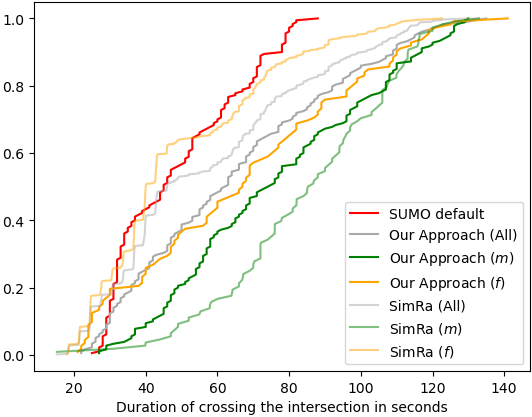

In [7]:
plt.xlabel('Duration of crossing the intersection in seconds')
ecdf = ECDF(durations_arr[0])
plt.plot(ecdf.x, ecdf.y, c='red', label='SUMO default')
ecdf = ECDF(durations_arr[1])
plt.plot(ecdf.x, ecdf.y, c='darkgrey', label='Our Approach (All)')
# ecdf = ECDF(durations_arr[2])
# plt.plot(ecdf.x, ecdf.y, c='blue', label='Our Approach (Slow)')
ecdf = ECDF(durations_arr[3])
plt.plot(ecdf.x, ecdf.y, c='green', label=r'Our Approach ($m$)')
ecdf = ECDF(durations_arr[4])
plt.plot(ecdf.x, ecdf.y, c='orange', label=r'Our Approach ($f$)')
ecdf = ECDF(simra_durations)
plt.plot(ecdf.x, ecdf.y, c='darkgrey', alpha=0.5, label='SimRa (All)')
# ecdf = ECDF(simra_durations_slow)
# plt.plot(ecdf.x, ecdf.y, c='blue', alpha=0.3, label='SimRa (Slow)')
ecdf = ECDF(simra_durations_medium)
plt.plot(ecdf.x, ecdf.y, c='green', alpha=0.5, label=r'SimRa ($m$)')
ecdf = ECDF(simra_durations_fast)
plt.plot(ecdf.x, ecdf.y, c='orange', alpha=0.5, label=r'SimRa ($f$)')
plt.legend()
params.update(**pdf_params)
plt.rcParams.update(params)
plt.savefig('images/im_alex_ecdf_every_group.pdf', bbox_inches='tight')
plt.show()

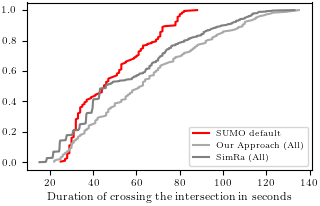

In [8]:
plt.xlabel('Duration of crossing the intersection in seconds')
ecdf = ECDF(durations_arr[0])
plt.plot(ecdf.x, ecdf.y, c='red', label='SUMO default')
ecdf = ECDF(durations_arr[1])
plt.plot(ecdf.x, ecdf.y, c='darkgrey', label='Our Approach (All)')
# ecdf = ECDF(durations_arr[5])
# plt.plot(ecdf.x, ecdf.y, c='black', label='Our Approach - indirect (All)')
ecdf = ECDF(simra_durations)
plt.plot(ecdf.x, ecdf.y, c='grey', label='SimRa (All)')
plt.legend()
# plt.xlim(0,200)
params.update(**pdf_params)
plt.rcParams.update(params)
plt.savefig('images/im_alex_ecdf_all.pdf', bbox_inches='tight')
plt.show()

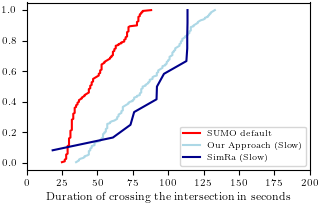

In [9]:
#plt.title('Empirical Cumulative Distribution Function')
plt.xlabel('Duration of crossing the intersection in seconds')
ecdf = ECDF(durations_arr[0])
plt.plot(ecdf.x, ecdf.y, c='r', label='SUMO default')
ecdf = ECDF(durations_arr[2])
plt.plot(ecdf.x, ecdf.y, c='lightblue', label='Our Approach (Slow)')
ecdf = ECDF(simra_durations_slow)
plt.plot(ecdf.x, ecdf.y, c='darkblue', label='SimRa (Slow)')
plt.legend()
plt.xlim(0,200)
params.update(**pdf_params)
plt.rcParams.update(params)
plt.savefig('images/im_alex_ecdf_slow.pdf', bbox_inches='tight')
plt.show()

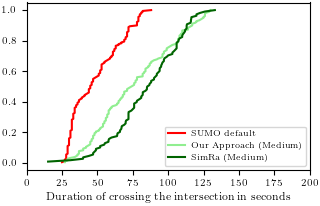

In [10]:
plt.xlabel('Duration of crossing the intersection in seconds')
ecdf = ECDF(durations_arr[0])
plt.plot(ecdf.x, ecdf.y, c='r', label='SUMO default')
ecdf = ECDF(durations_arr[3])
plt.plot(ecdf.x, ecdf.y, c='lightgreen', label='Our Approach (Medium)')
ecdf = ECDF(simra_durations_medium)
plt.plot(ecdf.x, ecdf.y, c='darkgreen', label='SimRa (Medium)')
plt.legend()
plt.xlim(0,200)
params.update(**pdf_params)
plt.rcParams.update(params)
plt.savefig('images/im_alex_ecdf_medium.pdf', bbox_inches='tight')
plt.show()

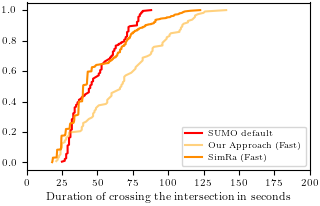

In [11]:
#plt.title('Empirical Cumulative Distribution Function')
plt.xlabel('Duration of crossing the intersection in seconds')
ecdf = ECDF(durations_arr[0])
plt.plot(ecdf.x, ecdf.y, c='red', label='SUMO default')
ecdf = ECDF(durations_arr[4])
plt.plot(ecdf.x, ecdf.y, c='orange', alpha=0.5, label='Our Approach (Fast)')
ecdf = ECDF(simra_durations_fast)
plt.plot(ecdf.x, ecdf.y, c='darkorange', label='SimRa (Fast)')
plt.legend()
plt.xlim(0,200)
params.update(**pdf_params)
plt.rcParams.update(params)
plt.savefig('images/im_alex_ecdf_fast.pdf', bbox_inches='tight')
plt.show()